## Домашняя работа #3.

Домашнее задание сдаётся в виде ссылки (с доступом комментатор или редактор) на Colab в опросе:
https://forms.gle/zemRsbegG9fQRVw76

Отправлять ссылку через форму нужно только один раз. Исправления вносятся в тот же ноутбук до хард-дедлайна и помечаются комментариями в коде и комментариями к соотвествующим ячейкам.

Материалы к домашке доступны по ссылке:
https://drive.google.com/drive/folders/1dNoAOMcrRyuf_3vS1LTPpdyrqYxgvPOy?usp=sharing



Большая домашка с увеличенным баллом и временем до дедлайна.
* Морфлогия.
* Фильтры габора.
* Цветовые гистрограммы.
* Гистограммы градиентов.


**Soft deadline: 25.03.2022 03:00:00 +0003 GMT**

**Hard deadline: 01.04.2022 03:00:00 +0003 GMT**

In [2]:
# ПРИМОНТИРУЙТЕ ДИСК К НОУТБУКУ
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [3]:
from pathlib import Path
# ИЗМЕНИТЕ ЭТОТ ПУТЬ НА ТОТ, КУДА ВЫ ПОЛОЖИЛИ МАТЕРИАЛЫ КУРСА
sources_path = Path("/content/drive/MyDrive/CVmaterials") 

In [12]:
import cv2
import numpy as np
import matplotlib.pylab as plt
import random
from ipywidgets import interact
import os
%matplotlib inline
plt.style.use('default')

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=kwargs.get('size', (10, 5)))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_bgr(img, size=(10, 5)):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


@pyplot
def show_gray(img, size=(10, 5)):
    plt.imshow(img, cmap='gray')

def mse(img1, img2):
    return ((img1.astype(int) - img2.astype(int)) ** 2).mean()



In [4]:
def plot_line(imgs, x=10, titles=None):
  n = len(imgs)
  plt.figure(figsize=(x, x))
  for i, img in enumerate(imgs):
    plt.subplot(1, n, i+1)
    plt.imshow(img, cmap="gray")
    if titles is not None:
      plt.title(titles[i])
    plt.axis('off')
    plt.tight_layout()

# МОРФОЛОГИЯ

**1. (5 баллов)** Выделите в изображении $table.jpg$ границы таблицы с использованием морфологических операций. Результатом обработки должно бытьn изображение, в котором удален весь текст и оставлены только границы таблицы.

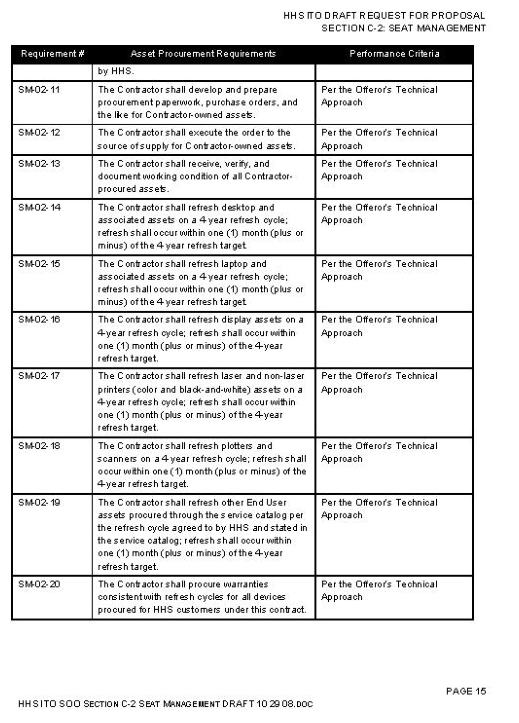

In [ ]:
table = cv2.imread(str(sources_path / "table.jpg"), 0)
show_gray(table, size=(5, 10))

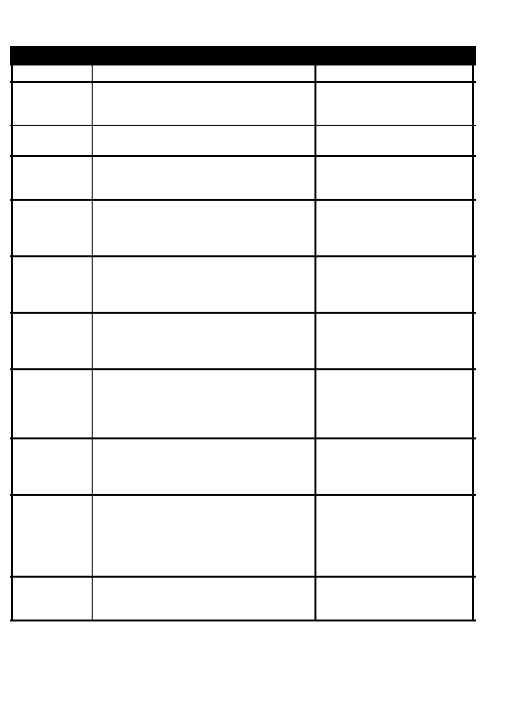

In [ ]:
image = cv2.bitwise_not(cv2.threshold(table,127,255,cv2.THRESH_BINARY)[1])

kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1,30))
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (30,1))
new_v = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel_v)
new_h = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel_h)
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
new_h = cv2.morphologyEx(new_h, cv2.MORPH_CLOSE, kernel_close)
result = cv2.bitwise_not(new_v+new_h)

show_gray(result, size=(5, 10))

**2. (5 баллов)** Для изображения $circles.jpg$ реализуйте морфологический алгоритм для построения трех изображений, которые бы содержали соответственно:

* только частицы, касающиеся краев изображения, 

* только группы перекрывающихся частиц,

* только одиночные круглые частицы.

Посчитайте число частиц и групп на каждом изображении. Раскрастье отдельные компоненты с помощью функции. 

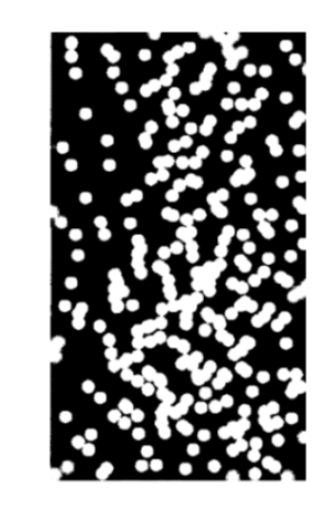

In [ ]:
circles = cv2.imread(str(sources_path / "circles.png"), 0)
show_gray(circles)
circles = cv2.threshold(circles,127,255,cv2.THRESH_BINARY)[1]
#print(circles)

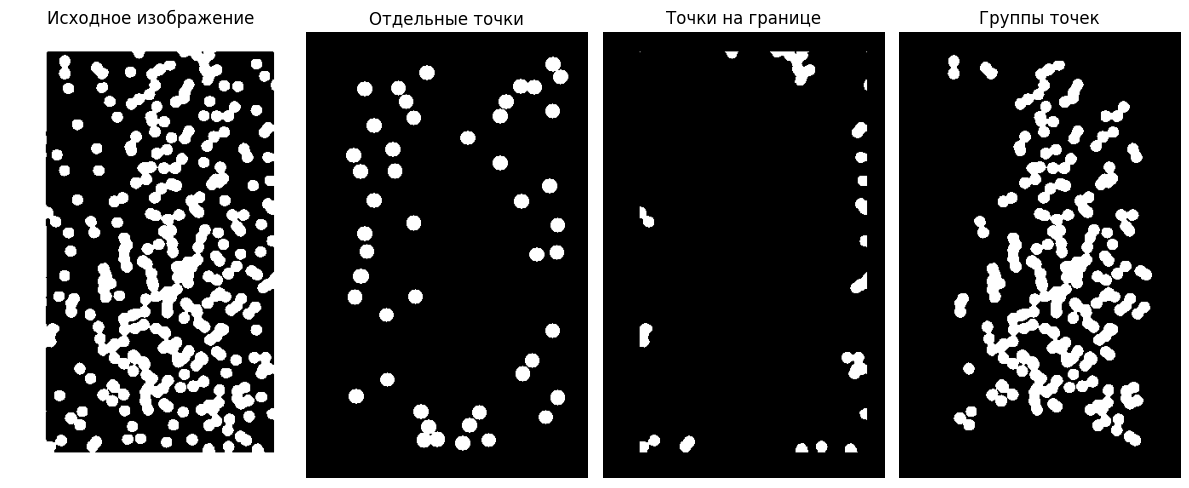

In [ ]:
def ker(l, h):
  kernel = np.zeros((l, l))
  kernel[:, 0] = -1
  kernel[0, :] = -1
  kernel[-1, :] = -1
  kernel[:, -1] = -1
  kernel[l//2-h//2:l//2+h//2, l//2-h//2:l//2+h//2] = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(h//2*2,h//2*2))
  return kernel


def frame(image):
    image[:24, :] = 0
    image[495:, :] = 0
    image[:, :43] = 0
    image[:, 310:] = 0
    return image

# выделяем одиночные круги 
kernel = ker(16, 2)
output_image = cv2.morphologyEx(circles, cv2.MORPH_HITMISS, kernel)
dilation = cv2.dilate(output_image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15)))
dilation = cv2.dilate(dilation, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))

# выделяем круги, близкие к границе, и обрезаем рамку
bond_circles = frame((cv2.connectedComponents(circles)[1] == 1)*255)

#выделяем перекрывающиеся частицы
group_circles = frame(circles - dilation - bond_circles).astype(np.uint8)
group_circles[group_circles == 1] =0

titles = ["Исходное изображение", "Отдельные точки", "Точки на границе", "Группы точек"]
circle_types =  [dilation, bond_circles, group_circles]
plot_line([circles]+circle_types, 12, titles=titles)

Отдельных точек 43
Точек на границе 20
Перекрывающихся точек 52


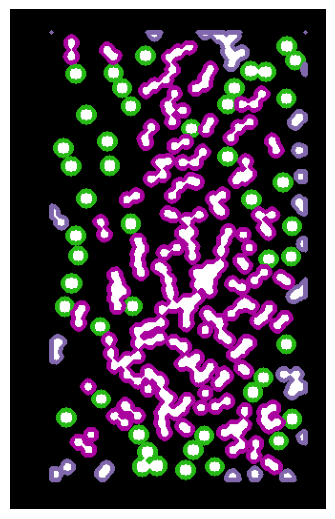

In [ ]:
colored = np.zeros((*circles.shape, 3), np.uint8)
lens = []
for img in circle_types:
  color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
  colored +=  cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
  contours, _ = cv2.findContours(img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(colored, contours, -1, color, 3)
  lens.append(len(contours))
print("Отдельных точек", lens[0])
print("Точек на границе", lens[1])
print("Перекрывающихся точек",lens[2])
show_bgr(colored)

**3. (5 баллов)** **Watershed**

* Возьмите изображения: *coins_1.jpg*, *coins_noize_1.jpg*
* Примените к ним алгоритм водораздела, чтобы посчитать монетки
* отсоритруйте монетки по размеру и у каждой моентки в центре впишите порядковое число

В сниппете кода содержится подсказка о том, какие функции стоит поприменять. 

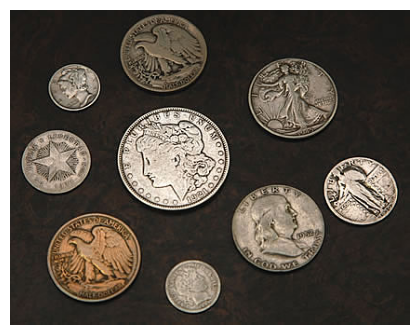

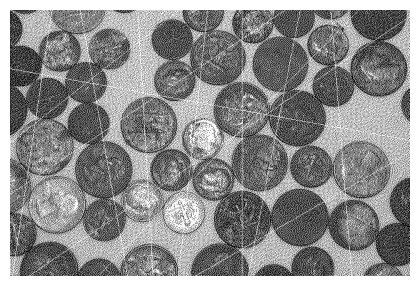

In [ ]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import scipy
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label
from cv2 import pyrMeanShiftFiltering
coins_1 = cv2.imread(str(sources_path / "coins_1.jpg"))
show_bgr(coins_1, size=(4, 5))
coins_2 = cv2.imread(str(sources_path / "coins_noize_2.jpg"))
show_bgr(coins_2, size=(4, 5))

In [ ]:
gray_coins_1 =  cv2.cvtColor(coins_1, cv2.COLOR_BGR2GRAY)
bin_coins_1 = cv2.threshold(gray_coins_1,45,255,cv2.THRESH_BINARY)[1]
def watershed_circ(thresh, min_dist=40):
  #алгоритм водораздела
  distance = distance_transform_edt(thresh)
  show_gray(distance)
  coords = peak_local_max(distance, min_distance=min_dist, labels=thresh) 
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers, num = label(mask)
  labels = watershed(-distance, markers, mask=thresh)
  #выделение кругов
  labels[labels!=0] = 255
  labels = np.uint8(labels)  
  labels = cv2.morphologyEx(labels, cv2.MORPH_CLOSE, np.ones((4,4)))
  labels = cv2.Canny(np.uint8(labels), 30, 150)
  cnt, _ = cv2.findContours(labels, cv2.RETR_EXTERNAL,
              cv2.CHAIN_APPROX_SIMPLE)
  return cnt
#заливка и отрисовка цифр
def draw_num(img, cnt):
  result = np.zeros(img.shape, "uint8")
  cnt.sort(key=lambda x: len(x))
  for item in cnt:
    color = tuple(map(int, np.random.randint(0, 255, size=3)))
    cv2.drawContours(result, [item], -1, color=color, thickness=-1)

  for idx, c in enumerate(cnt):
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    cv2.putText(result, str(idx + 1), (cX-10, cY+10),
                fontFace=cv2.FONT_HERSHEY_DUPLEX,
                fontScale=0.8,
                color=(0, 0, 0),
                thickness=1)
  show_bgr(result)


/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


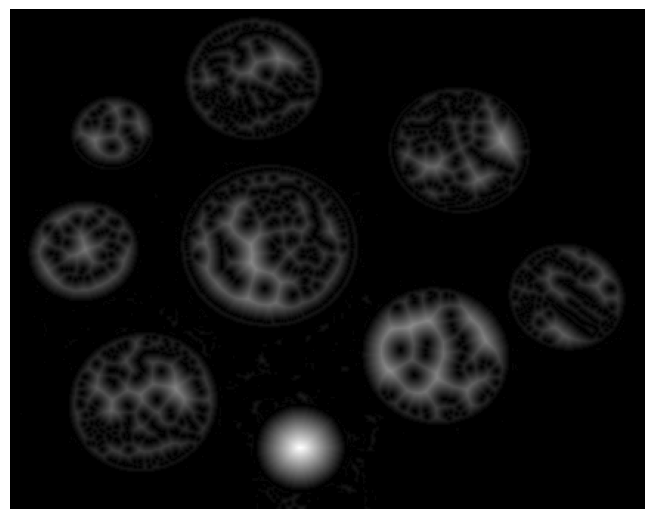

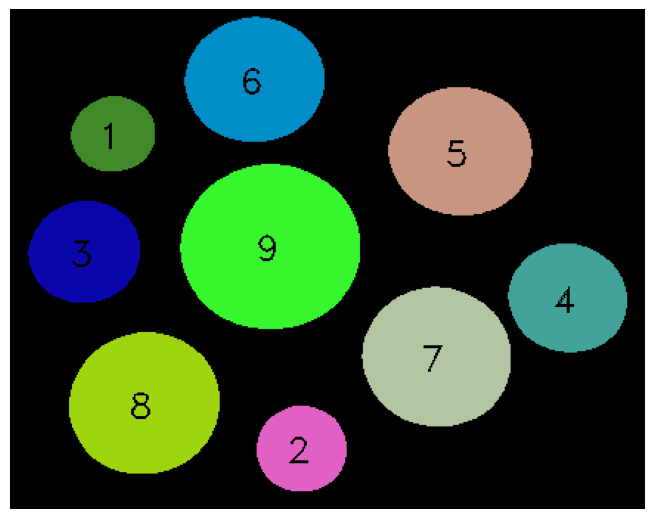

In [ ]:
cnt = watershed_circ(bin_coins_1)
draw_num(coins_1, cnt)

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


ZeroDivisionError: ignored

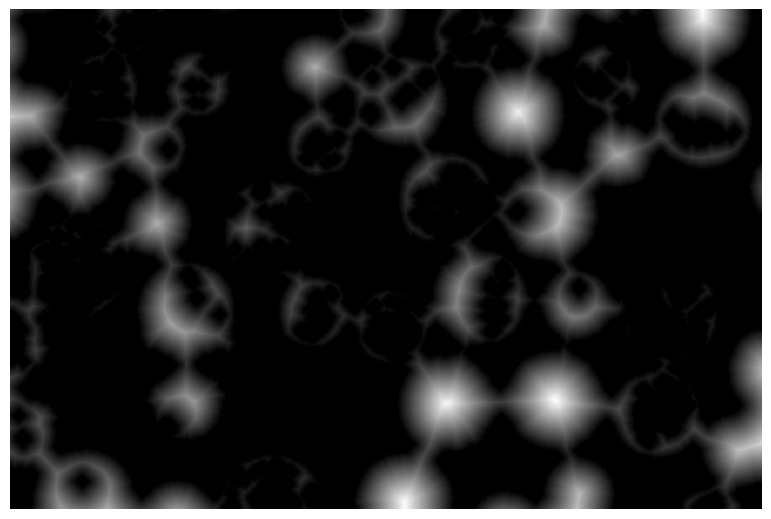

In [ ]:
#fltr= cv2.pyrMeanShiftFiltering(src =coins_2, sp = 25, sr = 40)
#show_bgr(fltr)
circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
image = cv2.pyrMeanShiftFiltering(src = cv2.medianBlur(coins_2,7), sp = 15, sr = 80).mean(2).astype('uint8')
image = cv2.bitwise_not(image)
for i in range(3):
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
  image = cv2.erode(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
image = cv2.erode(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
image = cv2.threshold(image,45,255,cv2.THRESH_BINARY)[1]
cnt = watershed_circ(image, min_dist=40)
draw_num(coins_2, cnt)
#show_gray(bin_coins_2)

# Фильтры габора

**4. (15 баллов)**  

Реализуйте функцию, которая построит банк фильтров Габора по входящим аргументам n, m. 
* n – число различных частот в дипазоне (0; max_freq]
* m - число различных напралений в диапазоне [0; Pi)

Продемонструйте, что предложенные фильтры более-менее плотно заполняют частотное просранство. Для этого переведите все фильтры в частотное пространство и отобразите все их одновременно на одной картинке. 

Реализуйте интерактивное demo в котром будут два слайдера, один отвечает за разные разные частоы, другой за разные направления. Выведите 3 изображения:
* Вид фильтра в пространстве изображений
* Вид Фильтра в частотном пространстве
* Результат применения фильтра к $lena.jpg$

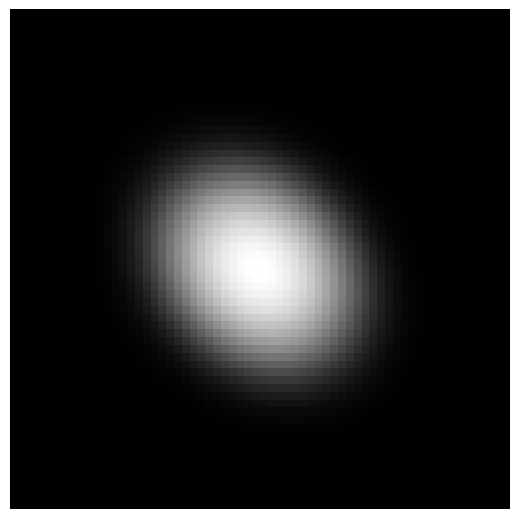

In [ ]:
def gabor(x, y, w_0=45, theta=-45, a=1/5, b=1/4, F_0=np.sqrt(2)/80, K=1):
  #все дополнительные параметры были взяты из статьи
  w_0 = np.pi*(w_0+90)/ 180
  theta = np.pi * theta / 180
  power = 2 * np.pi *(F_0 * x * np.cos(w_0) + F_0 *y *np.sin(w_0))
  s = np.array([np.cos(power), np.sin(power)])
  ax = a*(x*np.cos(theta) + y*np.sin(theta))
  by = b*(-x*np.sin(theta) + y*np.cos(theta))
  gauss = K*np.exp(-np.pi*(ax**2+by**2))
  return gauss*s


size = 32
filter = np.array([[gabor(x, y) for x in range(-size, size)] for y in range(-size, size)])

gabor_fourier = cv2.dft(np.float32(filter))
magn = np.fft.fftshift(np.log(1 + cv2.magnitude(gabor_fourier[:, :, 0], gabor_fourier[:, :, 1])))
show_gray(magn)

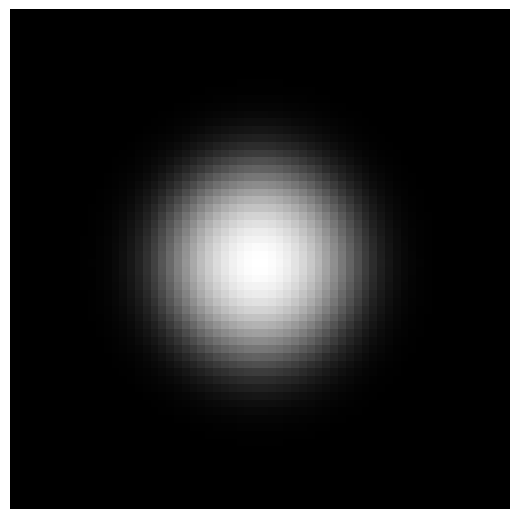

In [ ]:
def gabor_bank(n, m, max_freq=180, size=32):
  res = np.zeros((2*size, 2*size)).astype(np.float64)
  for theta in np.linspace(0, 180, n):
    for w_0 in np.linspace(0, max_freq, m):
      filter = np.array([[gabor(x, y, w_0, theta) for x in range(-size, size)] for y in range(-size, size)])
      gabor_fourier = cv2.dft(np.float32(filter))
      magn = np.fft.fftshift(np.log(1 + cv2.magnitude(gabor_fourier[:, :, 0], gabor_fourier[:, :, 1])))
      res += magn
  show_gray(res)
gabor_bank(10, 10)

In [ ]:
from ipywidgets import interact
max_freq=180
lena = cv2.imread(str(sources_path / "lena.jpg"), 0)
n, m = 5, 5
@interact(w_0=(0,max_freq, max_freq//m), theta=(0, 180, 180//n))
def gabor_show(w_0=45, theta=45):
  filter = np.array([[gabor(x, y, w_0, theta) for x in range(-size, size)] for y in range(-size, size)])
  gabor_fourier = cv2.dft(np.float32(filter))
  #show_gray(gabor_fourier[:, :, 0])
  magn = np.fft.fftshift(np.log(1 + cv2.magnitude(gabor_fourier[:, :, 0], gabor_fourier[:, :, 1])))
  lena_real = cv2.filter2D(lena, cv2.CV_32F, filter[:, :, 0])
  lena_img = cv2.filter2D(lena, cv2.CV_32F, filter[:, :, 1])
  lena_magn =cv2.magnitude(lena_real, lena_img)
  imgs = [filter[:,:, 0], filter[:,:, 1], magn, lena_magn]
  titles= ["Пространственное изображение, Re", "Пространственное изображение, Im", "Частотное пространство", "Применение к lena.jpg"]
  plot_line(imgs, x=15, titles=titles)

interactive(children=(IntSlider(value=45, description='w_0', max=180, step=36), IntSlider(value=45, descriptio…

# Цветовые гистрограммы.

**5. (15 баллов)**

Надо реализовать функцию, которая принимет на вход:

* список дескрипторов (**id**, и сам дескриптор) 
* количество максимально похожих для вывода **n**
* функцию сранения дескрипторов

и отдает **n** пар **id** максимально похожих изображений.

Посмотрите на изображения в папке *Corel*. Посчитайте гистограммы изображений. Выведите на экран 20 пар изображений с максимально похожими гистограммами, которые получаются для лучшей комбинации. В этом задании надо попробовать:
* различные цветовые пространства (RGB, HSV, CIELab)
* различные способы разбиения на бины (разное количество для каждой характеристики, joint_vs_marginal)
* различные метрики сравнения $L_2$, $\chi^2$, пересечение гистограм

Постройте сводную таблицу-отчет в которою впишите, сколько похожих пар получилось для каждого эксперимента. Проведите не менее 8 экспериментов и напишите какие-нибудь выводы

Увы, не успела :(

In [23]:
from torch.utils.data import Dataset

class ImgDataset(Dataset):
  def __init__(self):
    
    self.imgs = self.readimgs()
  
  def readimgs(self):
    imgs = []
    coral = os.path.join(sources_path, "corel")
    for name in os.listdir(coral):
      img = cv2.imread(coral+name)
    return imgs
  def __getitem__(self, i):
    return self.imgs[i]

In [24]:
data = ImgDataset()

In [27]:
class Histograms():
  def __init__(self, imgs=data, color_space="RGB", metric="L2", bins=256, hist_type="marginal"):
    if color_space == 'CIELab':
        self.color_to = cv2.COLOR_BGR2Lab
    elif color_space == "HSV":
        self.color_to = cv2.COLOR_BGR2HSV
    else:
        self.color_to = cv2.COLOR_BGR2RGB 
    self.metric = metric
    self.imgs = imgs
    self.bins = bins
    self.hist_type = hist_type
  
  def calculate_hist(self, img):
    if self.hist_type == "joint":
      hist = cv2.calcHist([img], [0, 1, 2], None, [256//self.bins, 256//self.bins, 256//self.bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
      return hist
    else:
      hist_1 = cv2.calcHist([img], [0], None, [256//self.bins], [0, 256])
      hist_2 = cv2.calcHist([img], [1], None, [256//self.bins], [0, 256])
      hist_3 = cv2.calcHist([img], [2], None, [256//self.bins], [0, 256])
      cv2.normalize(hist_1, hist_1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
      cv2.normalize(hist_2, hist_2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
      cv2.normalize(hist_3, hist_3, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
      return hist_1, hist_2, hist_3

  def compare_hist(self, img1, img2):
    if self.hist_type == "joint":
        hist1 = self.calculate_hist(img1)
        hist2 = self.calculate_hist(img2)
        if self.metric == 'xi2':
          d = cv2.compareHist(hist1, hist2, cv2.CV_COMP_CHISQR)
        elif self.metric == 'intersection':
          d = cv2.compareHist(hist1, hist2, cv2.CV_COMP_INTERSECT)
        else: 
          d = np.sum((hist1-hist2)**2)
        return d



# Гистограмма градиентов

**6. (10 баллов)**

Реализуйте функцию вычисления $HOG$ дескриптора для изображения, которая принимает на вход размер сетки. Визуализируйте полученный дескриптор на изображении *susi_example.jpg* с сетками размером 10x8 и 5x4. Просканируйте скользящим окном изображение *susi_gallery.jpg* и подсветите все области, дексриптор которых поход на дескриптор *susi_example.jpg*. В идеальном случае мы должны получить 3 изображения, для которых надо подобрать порог похожести:
* Та самая вырезанная сушина.
* Все суши с креветкой.
* Все суши, которые визуально похожи на суши с креветкой. 

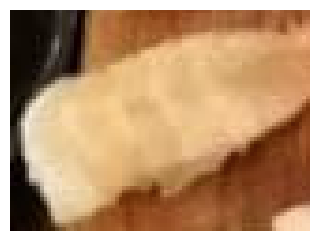

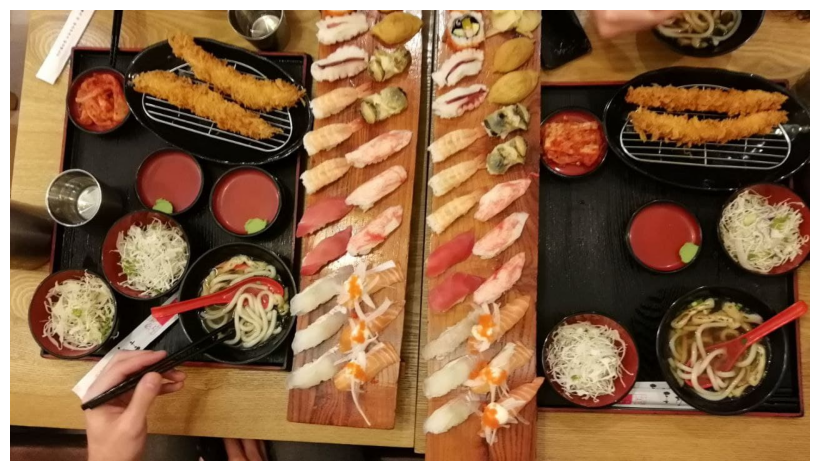

In [5]:
susi_example = cv2.imread(str(sources_path / "susi_example.jpg"))
show_bgr(susi_example, size=(3, 4))
susi_gallery = cv2.imread(str(sources_path / "susi_gallery.jpg"))
show_bgr(susi_gallery, size=(8, 16))

In [6]:
a = (10, 8) 
b = (5, 4) 

hog = cv2.HOGDescriptor(
    _winSize=(susi_example.shape[1] // a[1] * a[1], susi_example.shape[0] // a[0] * a[0]),
    _blockSize=(b[1] * a[1], b[0] * a[0]),
    _blockStride=(a[1], a[0]),
    _cellSize=(a[1], a[0]),
    _nbins=10)

target = hog.compute(susi_example) 
pieces = []
for i in range(0, susi_gallery.shape[0]-susi_example.shape[0], 12):
    for j in range(0, susi_gallery.shape[1]-susi_example.shape[1],16):
        window = susi_gallery[i:i+susi_example.shape[0], j:j+susi_example.shape[1]]
        test = hog.compute(window) 
        pieces.append([np.sum(np.abs(target - test)), i, j])
        
pieces = sorted(pieces, key=lambda x: x[0])

In [7]:
def box(img_, example, i, j):
    n, m, _ = example.shape
    img = img_.copy()
    img[i:i+5, j:j+m, 2] = 250
    img[i:i+n, j:j+5, 2] = 250
    img[i+n:i+n+5, j:j+m, 2] = 250
    img[i:i+n, j+m:j+m+5, 2] = 250
    return img

Вырезанная сушина


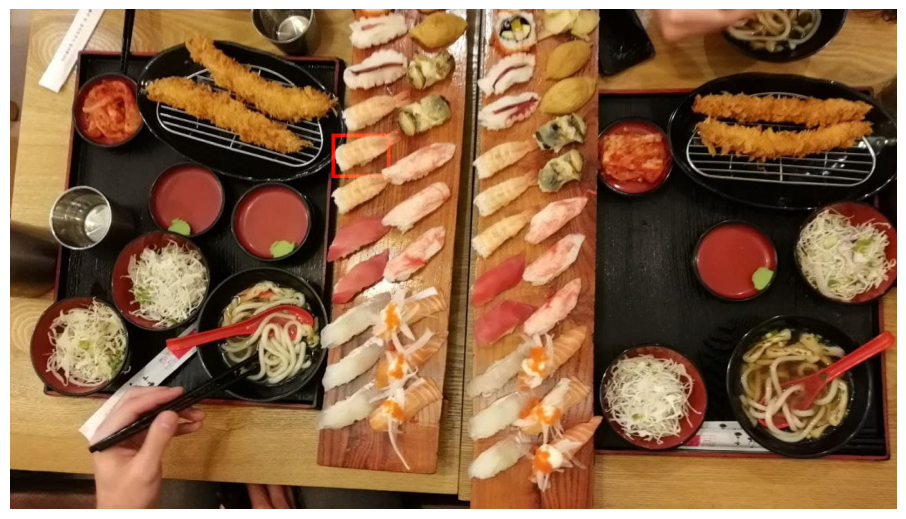

In [8]:
img = box(susi_gallery, susi_example, pieces[0][1], pieces[0][2])
show_bgr(img)
print("Вырезанная сушина")

Суши с креветкой


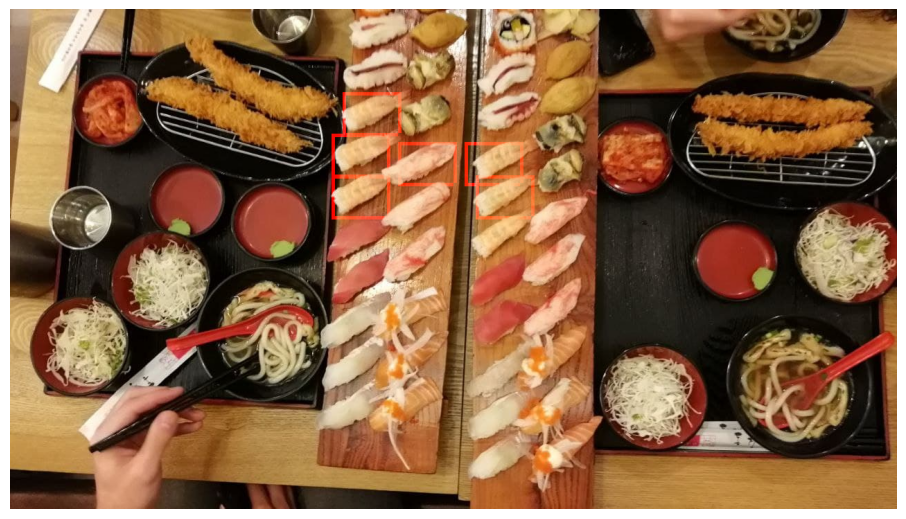

In [9]:
print("Суши с креветкой")
img = susi_gallery
for susi in pieces[:6]:
  img = box(img, susi_example, susi[1], susi[2])
show_bgr(img)

Похожие суши


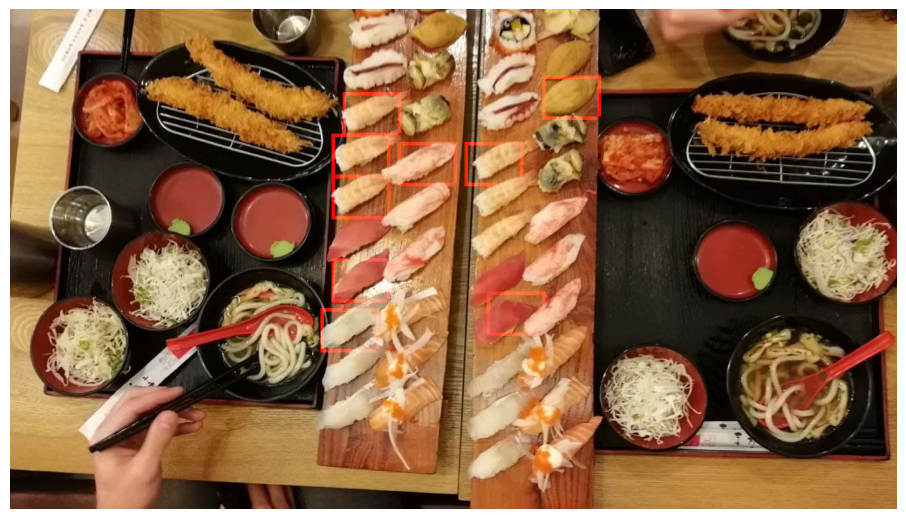

In [10]:
print("Похожие суши")
img = susi_gallery
overlap = []
for susi in pieces[:15]:
  isoverlapped=False
  for x, y in overlap:
    if (abs(susi[1]-x)<susi_example.shape[0]) and (abs(susi[2]-y) < susi_example.shape[1]):
      isoverlapped = True
  if not isoverlapped:
    img = box(img, susi_example, susi[1], susi[2])
  overlap.append([susi[1], susi[2]])
show_bgr(img)